# Feature space analysis

## Import libraries

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import os

## Load the dataset

The following function takes the name of the file and loads it as a Pandas DataFrame. Current file is set as P4D.csv. There are other files in the repository that can be analysed by exchanging the name of the load_file() function parameter file_name.

In [2]:
# Load the dataset

def load_file(file_name):
    """
    Loads a dataset from a specified file located in a predefined folder.

    This function accepts a file name, constructs the full file path based on a predefined
    folder location, and loads the file into a pandas DataFrame. It currently supports 
    CSV files and raises an error for unsupported file formats.

    Parameters:
    file_name (str): The name of the file to be loaded (including extension).

    Returns:
    pd.DataFrame or None: The loaded dataset as a pandas DataFrame if the file is 
                           in a supported format, or None if the file format is unsupported.

    Example usage:
    dataframe = load_file("+2-C.csv")
    """
    
    # Define the folder where the file is located
    folder_path = r"data"
    
    # Construct the full file path by joining folder path and file name
    file_path = os.path.join(folder_path, file_name)
    
    # Load the file into a pandas DataFrame based on its extension
    # Check the file extension to determine the appropriate loading method
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_path)  # Load CSV file into DataFrame
    else:
        print(f"Unsupported file format for {file_name}. Only .csv are supported.")
        return None  # Return None if the file format is not supported
    
    return df  # Return the loaded DataFrame
    
# Import the file
dataframe_n = load_file("P4D.csv")


## Designating features as a NumPy array

Columns that are not considered to be features in the dataset are dropped, and the remaining columns are converted into a NumPy array. This format is necessary for model compatibility.

In [3]:
# Extract the descriptor array
only_features_df = dataframe_n.drop(columns=['molecule_ChEMBL_ID', 'Cholestasis'])#, 'Dataset_label'])
descriptor_array = np.array(only_features_df)


## Dimensionality reduction model

In this step the function takes the feature set as a NumPy array and a string that indicates what type of the model will be used for dimensionality reduction. UMAP parameters were tuned to represent the cholestasis datasets.

In [4]:
# Function for dimensionality reduction
def dimension_reduction(array, model_type):
    """
    Perform dimensionality reduction using UMAP, PCA, or t-SNE.

    Parameters:
    - array (np.ndarray): Input array for dimensionality reduction
    - model_type (str): Type of model to use ('umap', 'pca', 'tsne')

    Returns:
    - np.ndarray: Transformed embeddings
    - model: Trained dimensionality reduction model
    """
    if model_type == 'umap':
        umap_model = umap.UMAP(metric = "euclidean",
                        n_neighbors = 30, # (1-200)
                        n_components = 2,
                        low_memory = False,
                        min_dist = 0.3, #(0-1)
                        random_state=42,
                        n_jobs=1,
                        learning_rate=0.2)
        
        embeddings = umap_model.fit_transform(array)
        return embeddings, umap_model
    
    elif model_type == 'pca':
        pca = PCA(n_components=2)
        embeddings = pca.fit_transform(array)
        return embeddings, pca
    
    elif model_type == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        embeddings = tsne.fit_transform(array)
        return embeddings, tsne
    
    else:
        raise ValueError("Invalid model type. Choose from 'umap', 'pca', or 'tsne'.")


In [5]:
# Perform dimensionality reduction
embeddings, reduction_model = dimension_reduction(descriptor_array, 'umap')


## 2D embedding labeling

Labels are added back to the feature embeddings for color encoded representation.

In [6]:
# Function to add labels to embeddings
def add_labels_to_embeddings(dataframe, embeddings):
    """
    Add labels and embeddings to the dataframe for visualization.

    Parameters:
    - dataframe (pd.DataFrame): Original dataframe
    - embeddings (np.ndarray): Transformed embeddings

    Returns:
    - pd.DataFrame: Updated dataframe with embeddings and labels
    """
    labels_df = dataframe.loc[:,['Cholestasis', 'molecule_ChEMBL_ID']]#.copy()#, 'Dataset_label']].copy()
    labels_df['x_embeddings'] = embeddings[:, 0]
    labels_df['y_embeddings'] = embeddings[:, 1]
    return labels_df

# Create a labeled dataframe
labeled_dataframe = add_labels_to_embeddings(dataframe_n, embeddings)


## Scatter plot

The function takes the labelled data frame of embeddings to produce a scatter plot. Red color was set to represent cholestasis positive, and green was set to represent cholestasis negative datapoints.

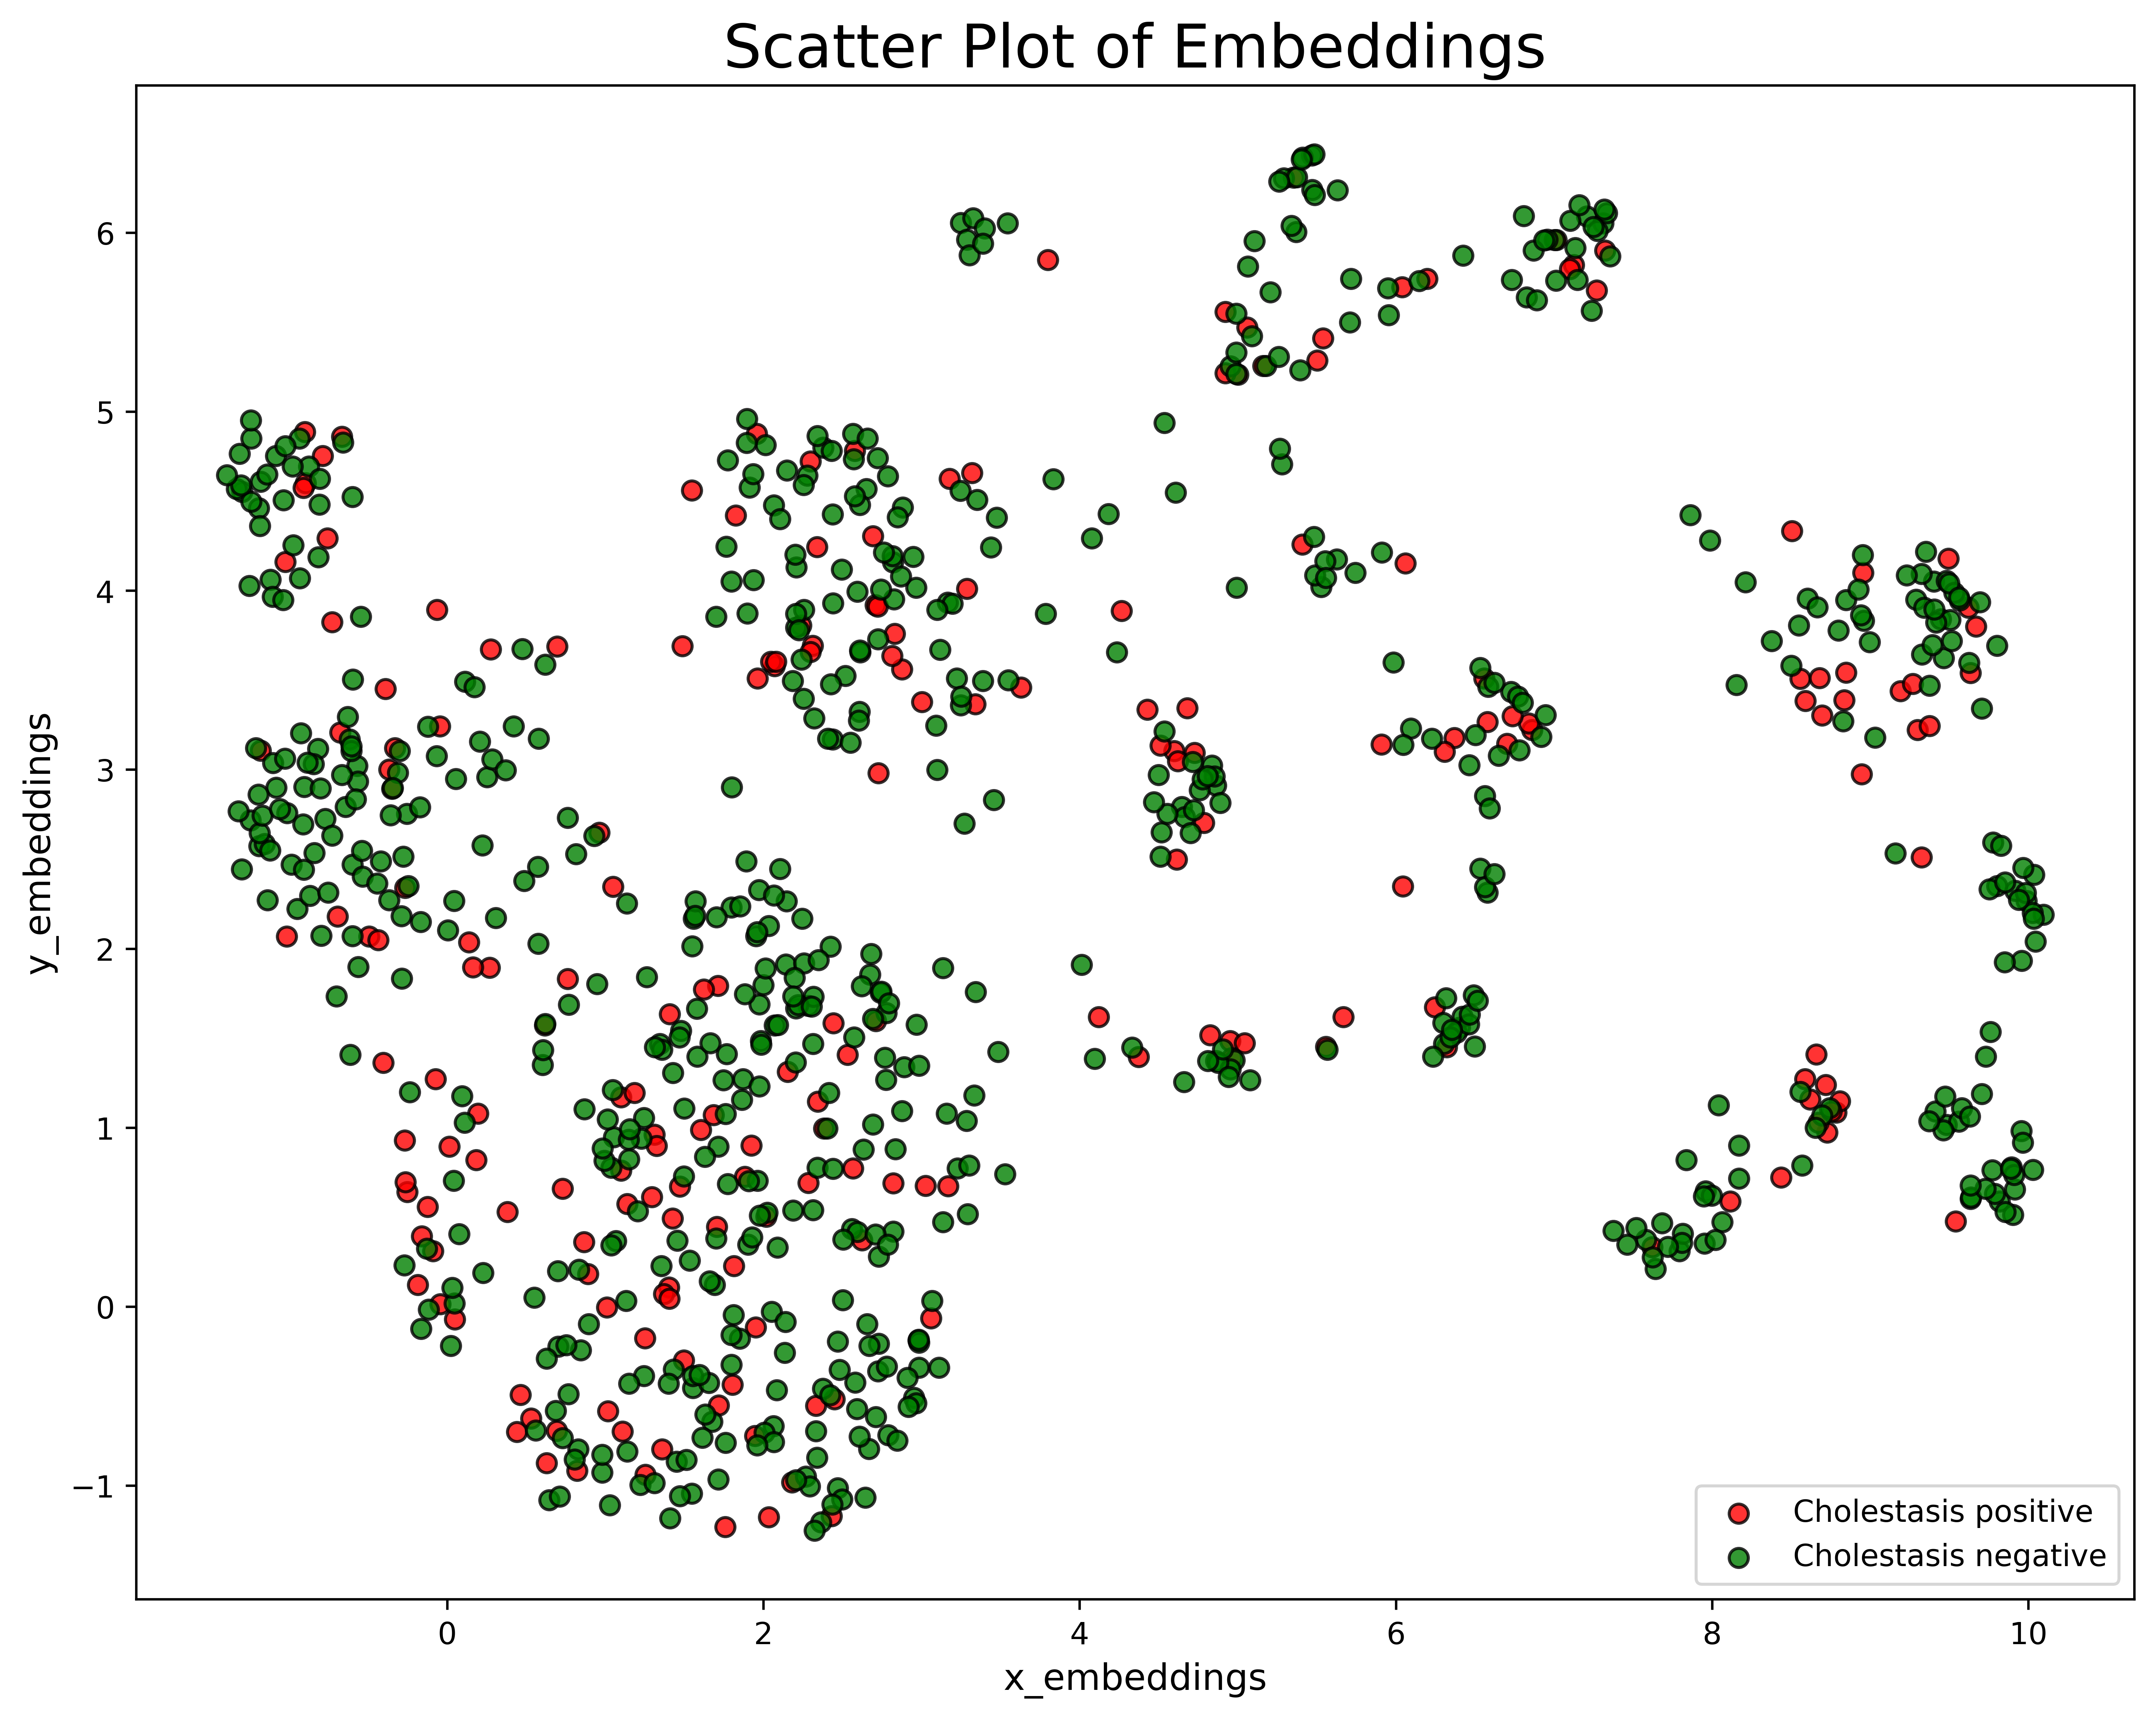

In [7]:
# Function to plot the feature space
def scatter_plot(df: pd.DataFrame) -> None:
    """
    Plots a scatter plot of embeddings for two groups based on the 'Cholestasis' column.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the following columns:
            - 'Cholestasis': Binary indicator (0 or 1).
            - 'x_embeddings': x-coordinates for plotting.
            - 'y_embeddings': y-coordinates for plotting.

    Returns:
        None: Displays a scatter plot.
    """
    # Separate the data based on 'Cholestasis' values
    chol_0 = df[df['Cholestasis'] == 0]
    chol_1 = df[df['Cholestasis'] == 1]

    # Plot parameters
    dot_size = 40
    colors = {'positive': 'red', 'negative': 'green'}

    plt.figure(figsize=(10, 8), dpi=600)
    plt.title("Scatter Plot of Embeddings", fontsize=20)

    # Scatter plot for positive and negative cholestasis
    chol_pos = plt.scatter(
        chol_1['x_embeddings'], chol_1['y_embeddings'], 
        c=colors['positive'], s=dot_size, edgecolors='black', 
        zorder=3, alpha=0.8, label='Cholestasis positive'
    )
    chol_neg = plt.scatter(
        chol_0['x_embeddings'], chol_0['y_embeddings'], 
        c=colors['negative'], s=dot_size, edgecolors='black', 
        zorder=3, alpha=0.8, label='Cholestasis negative'
    )

    # Axis labels and legend
    plt.xlabel('x_embeddings', fontsize=12)
    plt.ylabel('y_embeddings', fontsize=12)
    plt.legend(loc='lower right')

    # Show the plot
    plt.tight_layout()
    plt.show()


scatter_plot(labeled_dataframe)